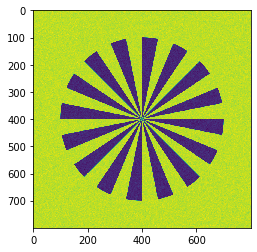

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import kornia
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from kornia.feature import *
from kornia.geometry import *

def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

img = Image.open('img/siemens.png')
# Image with synthetic pattern from SFOP paper: 
# http://www.ipb.uni-bonn.de/data-software/sfop-keypoint-detector/

timg = kornia.utils.image_to_tensor(np.array(img), keepdim=False).float() / 255. / 255. 
#Yes, it is not a typo. 
#This specific image somehow has [0, 255**2] range

plt.imshow(kornia.utils.tensor_to_image(timg[0]))

Kornia has a module ScaleSpaceDetector for local feature extraction.
It consists of several modules, each one is tunable and differentiable:

1. Scale pyramid
2. Responce (aka "cornerness")
3. Soft non-maxima-suppression
4. Affine shape detector
5. Orientation detector

The output is two tensors: with responces and with local affine frames (LAFs). You can feed LAFs to extract_patches function to then describe the corresponding patches

ScaleSpaceDetector(num_features=50, mr_size=6.0, scale_pyr=ScalePyramid(n_levels=3, init_sigma=1.6, min_size=10, border=4, sigma_step=1.2599210498948732double_image=False), resp=CornerHarris(k=tensor(0.0500), grads_mode=sobel), nms=ConvSoftArgmax3d(kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), temperature=tensor(1.), normalized_coordinates=False, eps=1e-08, strict_maxima_bonus=0.0, output_value=True), ori=PassLAF(), aff=PassLAF())


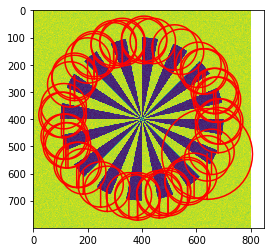

In [2]:
#Lets detect Harris corners
n_feats = 50
mr_size = 6.0 
nms = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1)) # nms windows size (scale, height, width)
harris = kornia.feature.responses.CornerHarris(0.05)

harris_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=harris,
                                    nms_module=nms,
                                    mr_size=mr_size)
print (harris_local_detector)
lafs, resps = harris_local_detector(timg)
visualize_LAF(timg,lafs)

You can see that there are lots of paired detections. 
That is because softargmax output (almost) same locations for nearby points.
To emulate classical non-maxima suppression, we could add "bonus" to responces, which are local maxima.
Thus, first detector would output all local maxima and only then the rest of points.

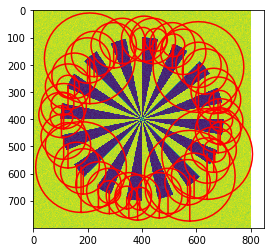

In [3]:
#Lets detect Harris corners w/o duplicates
n_feats = 50
mr_size = 6.0 
nms = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       strict_maxima_bonus=10.) # nms windows size (scale, height, width)

harris_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=harris,
                                    nms_module=nms,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg,lafs)


Now we are much better. But what about symmetrical responce functions, like Hessian or Difference of Gaussians,
where both minima and maxima are equally good points?
In that case we could pass **minima_are_also_good** flag to the  ScaleSpaceDetector.

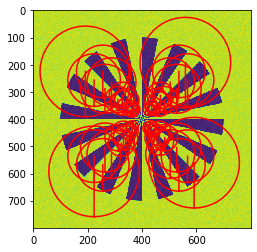

In [4]:
resp = kornia.feature.responses.BlobHessian()

hessian_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms,
                                    mr_size=mr_size, minima_are_also_good=True)
lafs, resps = hessian_local_detector(timg)
visualize_LAF(timg,lafs)

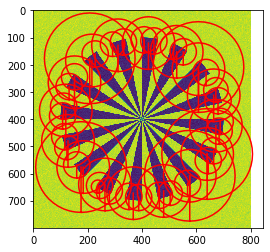

In [5]:
# Now Shi-Tomasi
gftt_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerGFTT(),
                                    nms_module=nms,
                                    mr_size=mr_size, minima_are_also_good=False)

lafs, resps = gftt_local_detector(timg)
visualize_LAF(timg,lafs)

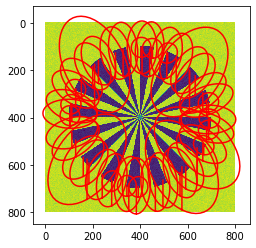

In [6]:
# What about Harris-Affine features?
harris_affine_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    minima_are_also_good=False)
lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

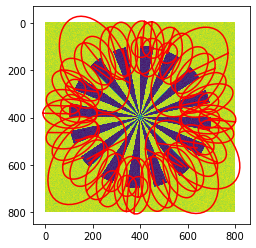

In [7]:
# Now lets also detect feature orientation
harris_affine_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    ori_module=kornia.feature.LAFOrienter(patch_size=19))

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

In [8]:
#Lets describe patches with SIFT descriptor
descriptor = kornia.SIFTDescriptor(32)

patches =  kornia.feature.extract_patches_from_pyramid(timg, lafs)
B, N, CH, H, W = patches.size()
# Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :) 
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
print (descs.shape)
print (descs[0, 0])

torch.Size([1, 50, 128])
tensor([0.0825, 0.0127, 0.0190, 0.0117, 0.2476, 0.0145, 0.0135, 0.0149, 0.2476,
        0.0098, 0.0492, 0.2046, 0.2476, 0.0324, 0.1899, 0.1524, 0.0130, 0.0096,
        0.0136, 0.0116, 0.0143, 0.0137, 0.0106, 0.0149, 0.0106, 0.0060, 0.0537,
        0.1639, 0.0147, 0.0097, 0.2127, 0.1845, 0.0088, 0.0187, 0.0108, 0.0152,
        0.0119, 0.0144, 0.0191, 0.0114, 0.0079, 0.0095, 0.0119, 0.0122, 0.0071,
        0.0070, 0.0129, 0.0150, 0.0111, 0.0241, 0.0152, 0.0217, 0.0111, 0.0217,
        0.0151, 0.0221, 0.0098, 0.0213, 0.0246, 0.0237, 0.0071, 0.0174, 0.0155,
        0.0224, 0.0129, 0.0172, 0.0170, 0.0160, 0.0084, 0.1562, 0.0650, 0.0167,
        0.0067, 0.2476, 0.1090, 0.0083, 0.0050, 0.2476, 0.0427, 0.0162, 0.0132,
        0.0099, 0.0127, 0.0104, 0.0072, 0.1049, 0.0563, 0.0108, 0.0066, 0.1619,
        0.0517, 0.0093, 0.0038, 0.1700, 0.0157, 0.0058, 0.0728, 0.0194, 0.0145,
        0.0200, 0.0343, 0.1202, 0.1914, 0.0324, 0.0058, 0.0221, 0.1540, 0.1101,
        0.0067,